<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C10A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)

In [143]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# 整理資料

In [144]:
test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]#5不可整除
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]#5可以整除
train = train.append(test_200)#200筆加入train
print(train.shape)#4721
print(test_170.shape)#170
print(test_50.shape)#50

(4721, 27)
(170, 27)
(50, 27)


# def features y_name

In [0]:
features = ['T10','T50','T90','N+A']
y_name = 'C10A'

# features scaler

In [146]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train[features])

train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.457444,0.556351,0.439809,-1.047568,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,0.379525,0.366234,0.226254,-1.096167,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,0.414156,0.497854,0.247610,-1.122719,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,0.448786,0.468605,-0.328987,-1.109799,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,0.448786,0.395483,-0.478475,-1.022438,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# CORR WITH X

找找高相關特徵

In [147]:
corr_x = train[features+[y_name]].corr()
corr_x

,T10,T50,T90,N+A,C10A
T10,1.000000,0.895238,0.222087,-0.262210,-0.196389
T50,0.895238,1.000000,0.533778,-0.371996,0.028666
T90,0.222087,0.533778,1.000000,-0.217989,0.601330
N+A,-0.262210,-0.371996,-0.217989,1.000000,0.169956
C10A,-0.196389,0.028666,0.601330,0.169956,1.000000


# CORR WITH Y

找找高相關y

In [148]:
corr_y = abs(train.iloc[:,4:].corr())[[y_name]].sort_values(by=y_name,ascending=False).T
corr_y

,C10A,C10N,C10NP,C7NP,C8NP,C8IP,C10IP,C7IP,C5NP,C9NP,C9IP,C9A,C5IP,C6IP,C7A,C8N,C9N,C6A,C7N,C5N,C8A,C6N,C6NP
C10A,1.0,0.608718,0.495984,0.341963,0.331432,0.290339,0.282703,0.264663,0.223847,0.222245,0.184332,0.151667,0.14791,0.147246,0.143193,0.141746,0.116914,0.105128,0.091675,0.077997,0.070466,0.057961,0.014616


# 特徵工程

In [0]:
train['F1'] = train['T90'] -train['T10']
test_170['F1'] = test_170['T90'] -test_170['T10']
test_50['F1'] = test_50['T90'] - test_50['T10']

# 檢查相關性

這裡希望看到是漂亮的線性相關

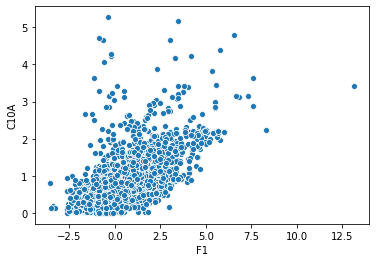

,F1,C10A
F1,1.000000,0.639542
C10A,0.639542,1.000000


In [150]:
sns.scatterplot(x='F1',y=y_name,data=train)
plt.show()
train.corr().loc[['F1',y_name],['F1',y_name]]

# modeling

評分指標

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p,name):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

In [152]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#選擇模型
#model = DecisionTreeRegressor(max_depth=3)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
#model = SVR()
model = LinearRegression()

#交叉驗證
val_scores = cross_validate(model,train[['F1']],train[y_name],cv=5)

#交叉驗證結果
print('交叉驗證分數:',val_scores['test_score'])
print('交叉驗證平均分數:',val_scores['test_score'].mean())

交叉驗證分數: [-0.91433797  0.30269776  0.66337561  0.27993969  0.41633319]
交叉驗證平均分數: 0.14960165662000757


# fit & predict

In [0]:
# fit 
model.fit(train[['F1']],train[y_name])
# predict
train['y_pred'] = model.predict(train[['F1']])
test_170['y_pred'] = model.predict(test_170[['F1']])
test_50['y_pred'] = model.predict(test_50[['F1']])

# plot

data for plot

In [0]:
by_col = 'F1'
train_sample_point = train.sample(1000).sort_values(by = by_col)
test_170_point = test_170.sort_values(by = by_col)
test_50_point = test_50.sort_values(by = by_col)

plot function

In [0]:
def pred_plot(df,by_col,name):
  plt.plot(df[by_col],df['y_pred'],label= name+'_pred',color='red')
  plt.scatter(df[by_col],df[y_name],label= name+'_point')
  plt.xlabel(by_col)
  plt.ylabel(y_name)
  plt.legend()

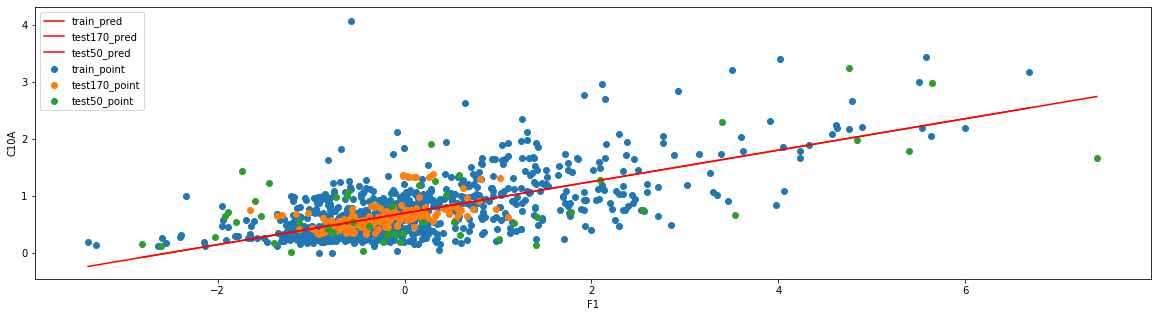

,R2,RMSE,mean_absolute_error
train,0.409014,0.414500,0.270201
test170,0.291016,0.196259,0.133018
test50,0.379217,0.559284,0.464664


In [156]:
fig = plt.figure(figsize=(20,5))

pred_plot(train_sample_point,by_col,name='train')
pred_plot(test_170_point,by_col,name='test170')
pred_plot(test_50_point,by_col,name='test50')
plt.show()

metric(train[y_name],train['y_pred'],name='train').append(
metric(test_170[y_name],test_170['y_pred'],name='test170')).append(
metric(test_50[y_name],test_50['y_pred'],name='test50'))

# check outliers

In [157]:
loss = (test_170_point[y_name] - test_170_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)#排序
#新增out欄位
test_170_point['out'] = False 
test_170_point.loc[loss[loss>0.4].index,'out'] = True
print(loss.head(5))

19    0.454729
11    0.422203
12    0.407514
18    0.390993
17    0.376196
dtype: float64


In [158]:
loss = (test_50_point[y_name] - test_50_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)#排序
#新增out欄位
test_50_point['out'] = False
test_50_point.loc[loss[loss>0.4].index,'out'] = True
print(loss.head(5))

175    1.520609
140    1.493509
70     1.286644
100    1.163803
45     1.015760
dtype: float64


# plot out

In [0]:
def d_out_score(df,name):
  df = df.loc[df['out'] == False]
  return metric(df[y_name],df['y_pred'],name)

In [0]:
def plot_out(df):
  fig = plt.figure(figsize=(20,5))
  out_point = df[df['out'] == True]
  plt.plot(df[by_col],df['y_pred'],label='pred line',color='red')
  plt.scatter(df[by_col],df[y_name],label='test point')
  plt.scatter(out_point[by_col],out_point[y_name],label='out point',color='orange')
  plt.xlabel(by_col)
  plt.ylabel(y_name)
  plt.legend()
  plt.show()

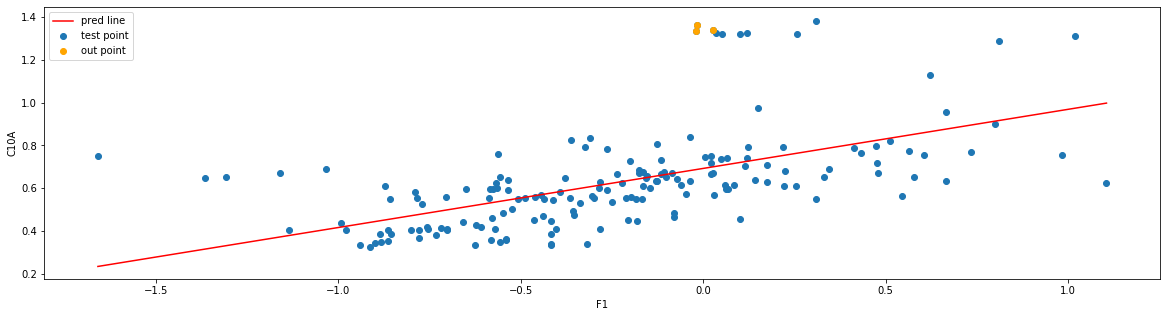

,R2,RMSE,mean_absolute_error
test170,0.31569,0.177534,0.123657


In [161]:
plot_out(test_170_point)
plt.show()
d_out_score(test_170_point,'test170')

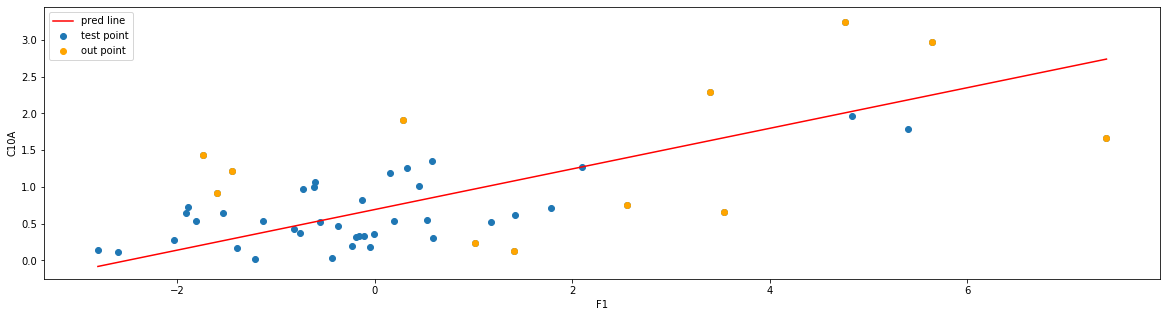

,R2,RMSE,mean_absolute_error
test50,0.371987,0.363973,0.322337


In [162]:
plot_out(test_50_point)
plt.show()
d_out_score(test_50_point,'test50')